In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta

In [97]:
# Load data
data = pd.read_csv("/kaggle/input/coffee-sales/coffee_sales.csv")


In [98]:
# Convert the date column to datetime and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [99]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
datetime        0
cash_type       0
card           89
money           0
coffee_name     0
dtype: int64


In [100]:
# Fill missing values for 'card' column with 'Unknown' if applicable
if 'card' in data.columns:
    data['card'] = data['card'].fillna('Unknown')

In [101]:
# -----------------------------------------
# Task 1: Time Series Exploratory Data Analysis (EDA)
# -----------------------------------------

In [102]:
# Grouping by date to get total sales per day
daily_sales = data.resample('D')['money'].sum()

In [103]:
# Statistical Summary
print("\nStatistical Summary of Daily Sales:")
print(daily_sales.describe())


Statistical Summary of Daily Sales:
count    153.000000
mean     245.156078
std      130.397282
min        0.000000
25%      148.440000
50%      228.100000
75%      330.140000
max      650.480000
Name: money, dtype: float64


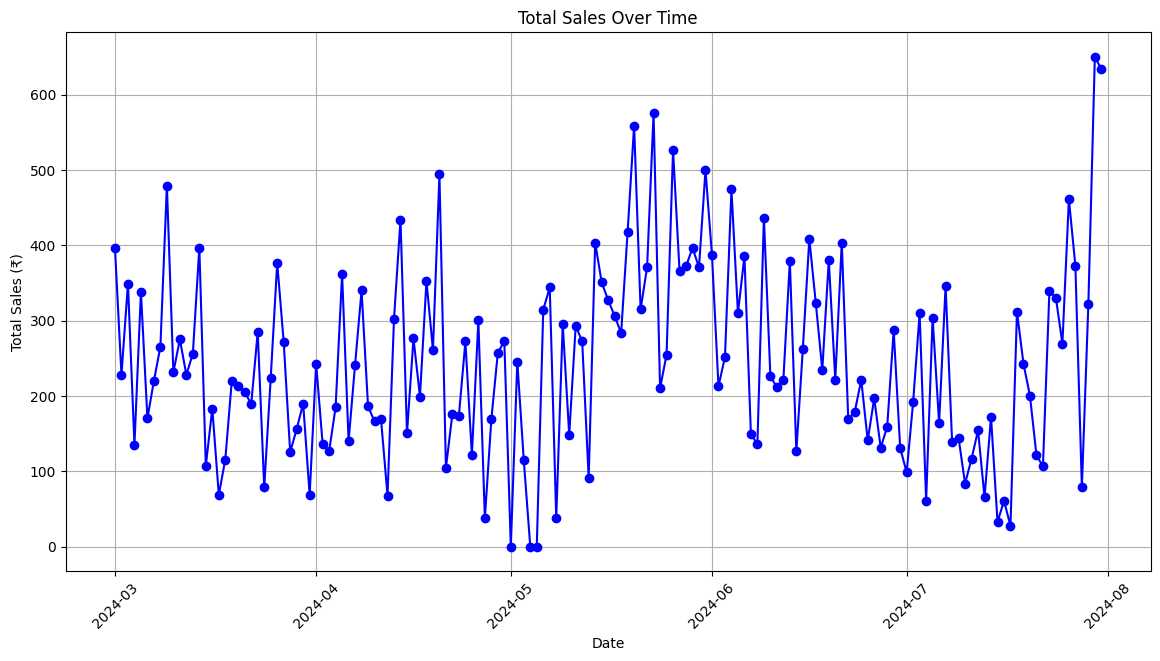

In [104]:
# Plotting daily sales
plt.figure(figsize=(14, 7))
plt.plot(daily_sales, marker='o', color='blue')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [105]:
# Moving Average Calculation
moving_average = daily_sales.rolling(window=7).mean()

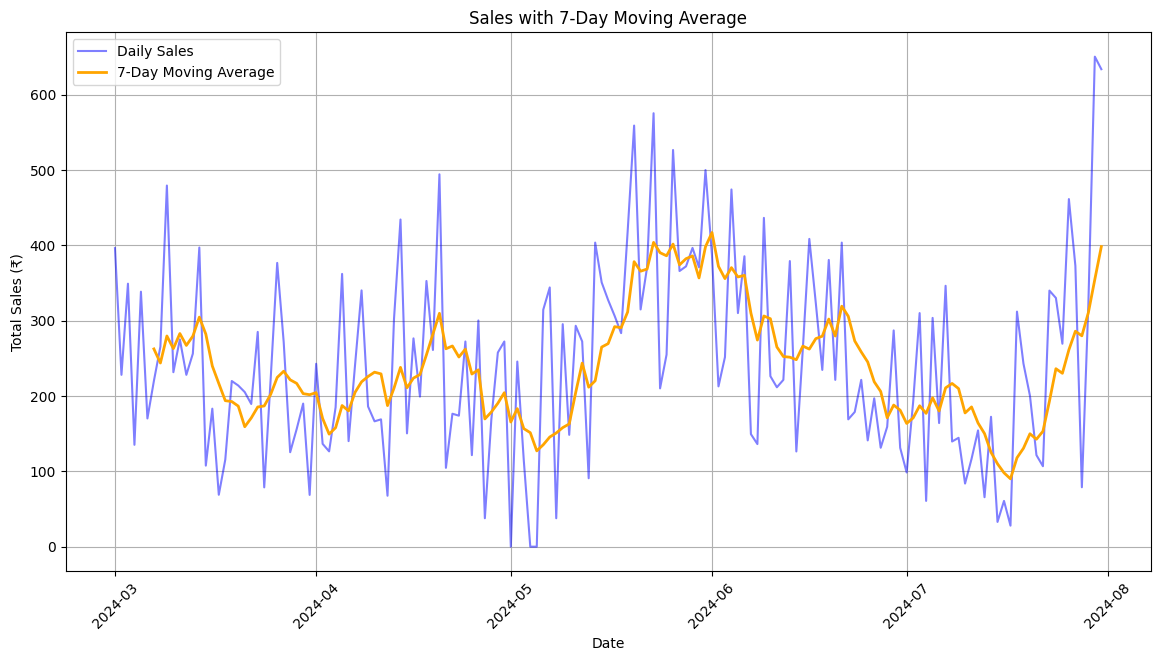

In [106]:
# Plotting Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(daily_sales, label='Daily Sales', color='blue', alpha=0.5)
plt.plot(moving_average, label='7-Day Moving Average', color='orange', linewidth=2)
plt.title('Sales with 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

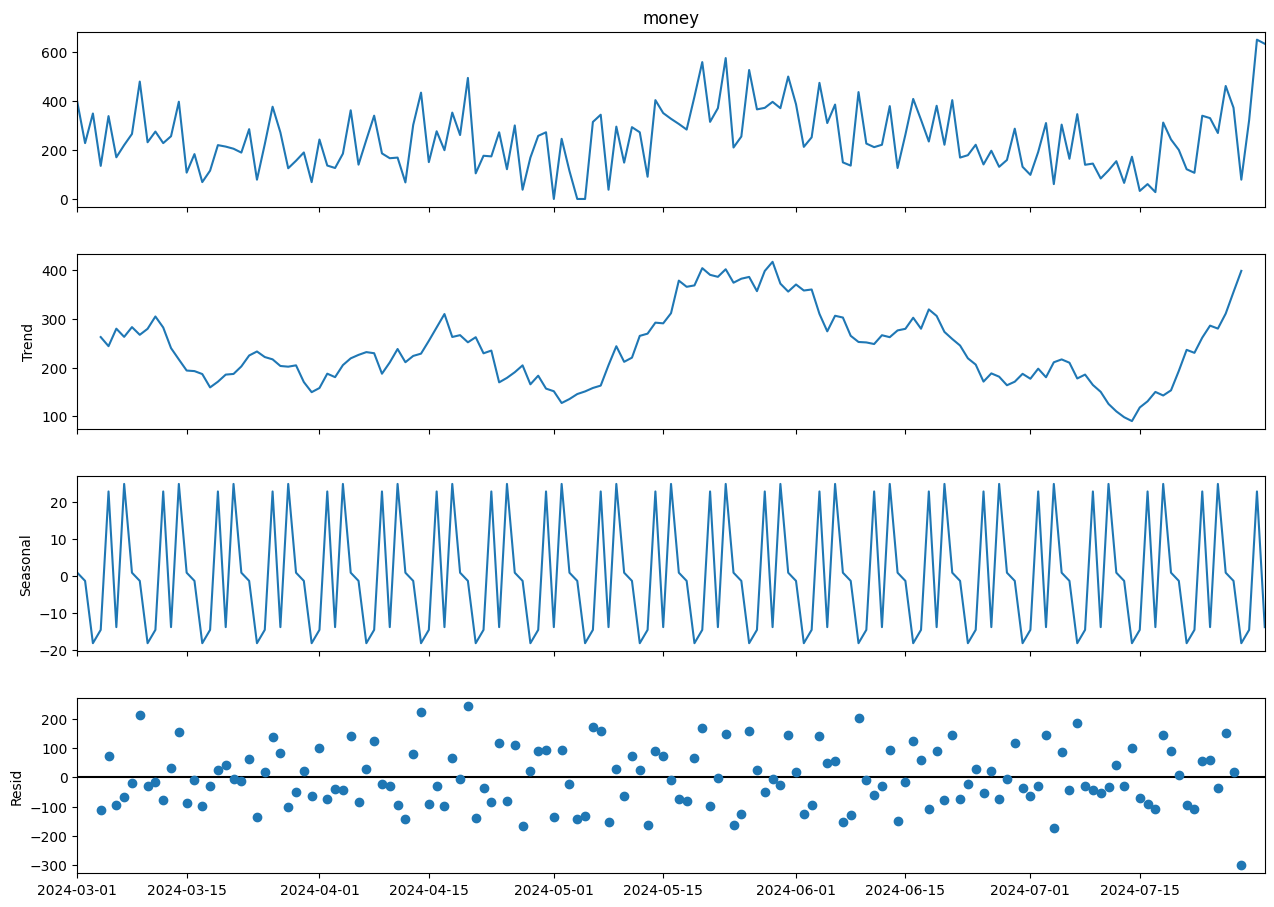

In [107]:
# Seasonal Decomposition
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)  # Weekly seasonality
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [108]:
# ADF Test for Stationarity
adf_result = adfuller(daily_sales)
print("\nADF Statistic: ", adf_result[0])
print("p-value: ", adf_result[1])

if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Consider differencing.")


ADF Statistic:  -2.3950547665243387
p-value:  0.14313703179962733
The time series is not stationary. Consider differencing.


<Figure size 1400x700 with 0 Axes>

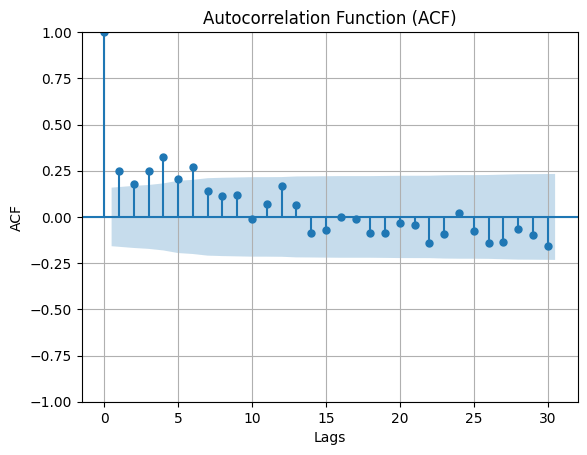

In [109]:
# Autocorrelation Plot
plt.figure(figsize=(14, 7))
plot_acf(daily_sales, lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid()
plt.show()

<Figure size 1400x700 with 0 Axes>

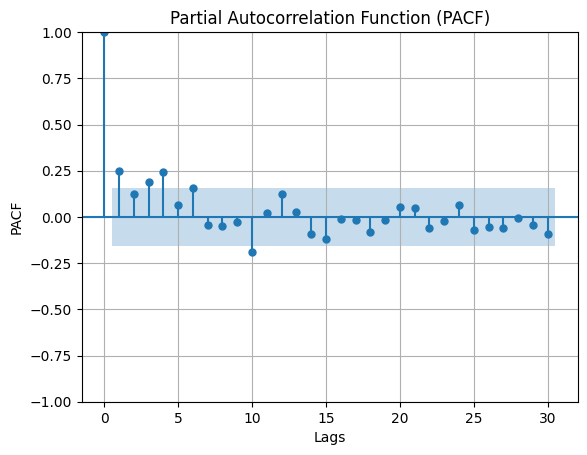

In [110]:
# Partial Autocorrelation Plot
plt.figure(figsize=(14, 7))
plot_pacf(daily_sales, lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid()
plt.show()

In [111]:
# Anomaly Detection
threshold = daily_sales.mean() + 2 * daily_sales.std() 
anomalies = daily_sales[daily_sales > threshold]

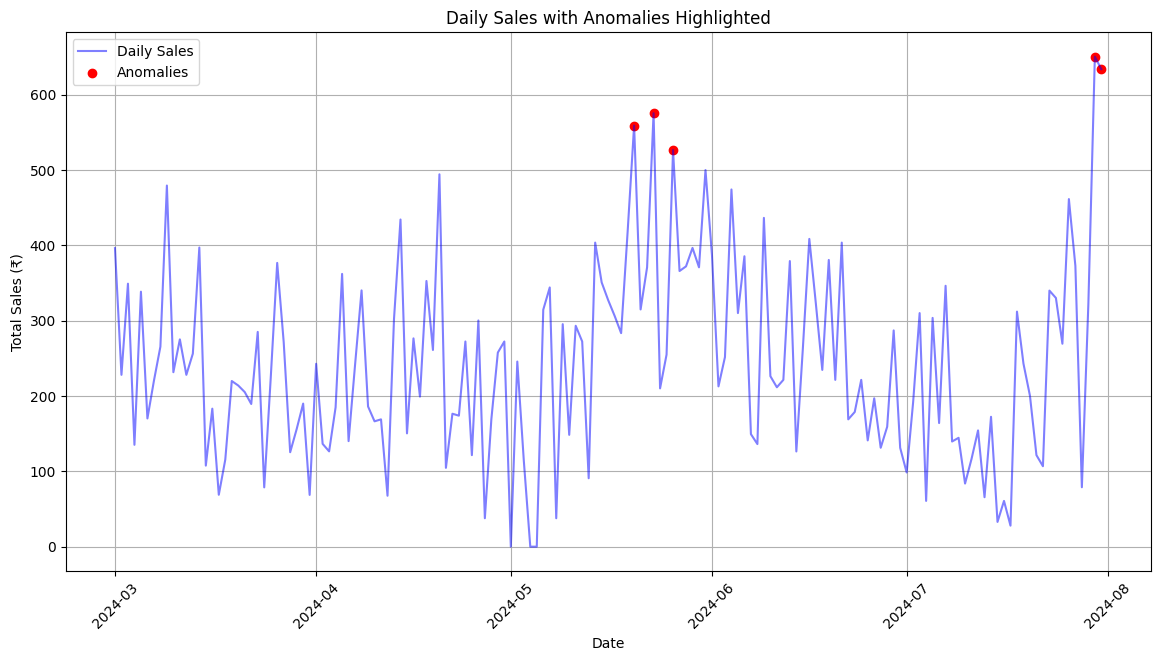

In [112]:
# Plotting Anomalies
plt.figure(figsize=(14, 7))
plt.plot(daily_sales, label='Daily Sales', color='blue', alpha=0.5)
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies', marker='o')
plt.title('Daily Sales with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [113]:
# -----------------------------------------
# Task 2: Next Day/Week/Month Sales Prediction
# -----------------------------------------

In [114]:
# Forecasting using Exponential Smoothing
model = ExponentialSmoothing(daily_sales, trend='add', seasonal='add', seasonal_periods=7)
model_fit = model.fit()

In [115]:
# Forecasting for the next 30 days
forecast_days = 30
forecast_exp = model_fit.forecast(forecast_days)
forecast_index = pd.date_range(start=daily_sales.index[-1] + timedelta(days=1), periods=forecast_days)
forecast_exp_series = pd.Series(forecast_exp, index=forecast_index)

In [116]:
# Fit ARIMA model
arima_model = ARIMA(daily_sales, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

In [117]:
# Forecasting for the next 30 days using ARIMA
arima_forecast = arima_model_fit.forecast(steps=forecast_days)
arima_forecast_series = pd.Series(arima_forecast, index=forecast_index)

In [118]:
# Forecasting using SARIMA
sarima_model = SARIMAX(daily_sales, order=(5, 1, 0), seasonal_order=(1, 1, 1, 7)) 
sarima_model_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02620D+00    |proj g|=  8.66234D-02

At iterate    5    f=  6.00475D+00    |proj g|=  2.00781D-02


 This problem is unconstrained.



At iterate   10    f=  6.00292D+00    |proj g|=  2.42154D-03

At iterate   15    f=  5.96052D+00    |proj g|=  6.93015D-02

At iterate   20    f=  5.94165D+00    |proj g|=  8.01044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     27      1     0     0   2.439D-05   5.942D+00
  F =   5.9416496261287115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [119]:
# Forecasting for the next 30 days using SARIMA
sarima_forecast = sarima_model_fit.forecast(steps=forecast_days)
sarima_forecast_series = pd.Series(sarima_forecast, index=forecast_index)

In [120]:
# Forecasting for the next 30 days using ARIMA
arima_forecast = arima_model_fit.forecast(steps=forecast_days)
arima_forecast_series = pd.Series(arima_forecast, index=forecast_index)

In [121]:
# Evaluate Forecast Accuracy
def evaluate_forecast(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse, rmse

In [122]:
# Compare the forecasted values with historical values
recent_actual = daily_sales[-forecast_days:]  # Last 30 days of actual data for evaluation
mse_exp, rmse_exp = evaluate_forecast(recent_actual, forecast_exp_series[:len(recent_actual)])
mse_arima, rmse_arima = evaluate_forecast(recent_actual, arima_forecast_series[:len(recent_actual)])
mse_sarima, rmse_sarima = evaluate_forecast(recent_actual, sarima_forecast_series[:len(recent_actual)])

In [123]:
# Display results
print(f'Exponential Smoothing - MSE: {mse_exp:.2f}, RMSE: {rmse_exp:.2f}')
print(f'ARIMA - MSE: {mse_arima:.2f}, RMSE: {rmse_arima:.2f}')
print(f'SARIMA - MSE: {mse_sarima:.2f}, RMSE: {rmse_sarima:.2f}')

Exponential Smoothing - MSE: 66916.73, RMSE: 258.68
ARIMA - MSE: 74071.67, RMSE: 272.16
SARIMA - MSE: 85486.48, RMSE: 292.38


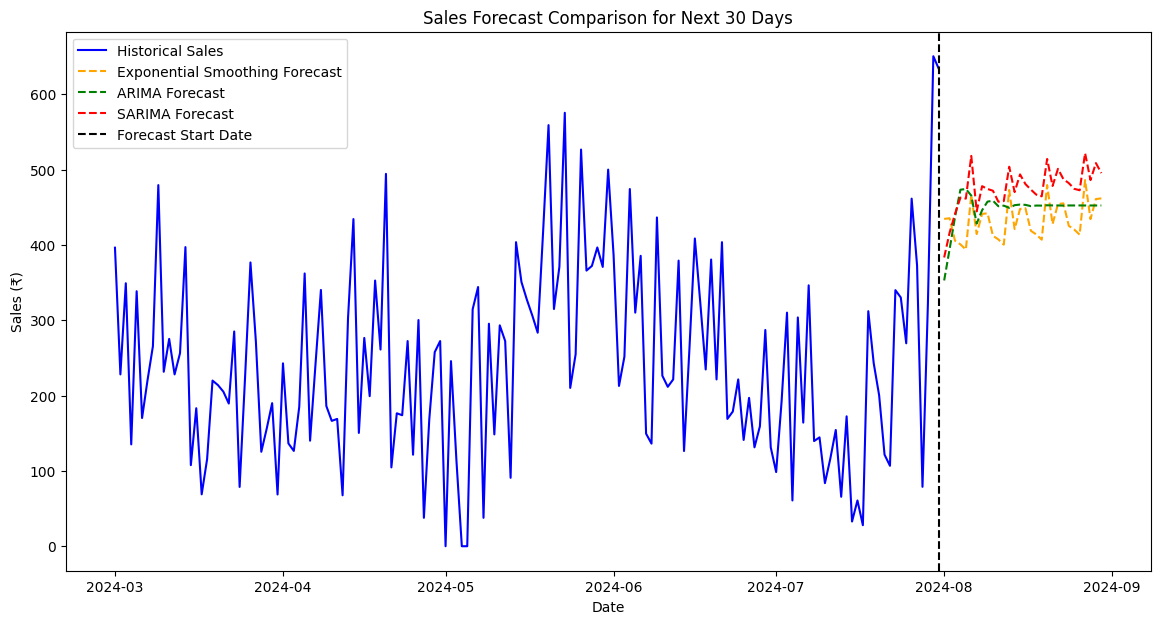

In [124]:
# Plotting the forecasts
plt.figure(figsize=(14, 7))
plt.plot(daily_sales, label='Historical Sales', color='blue')
plt.plot(forecast_exp_series, label='Exponential Smoothing Forecast', color='orange', linestyle='--')
plt.plot(arima_forecast_series, label='ARIMA Forecast', color='green', linestyle='--')
plt.plot(sarima_forecast_series, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('Sales Forecast Comparison for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Sales (₹)')
plt.axvline(x=daily_sales.index[-1], color='black', linestyle='--', label='Forecast Start Date')
plt.legend()
plt.show()

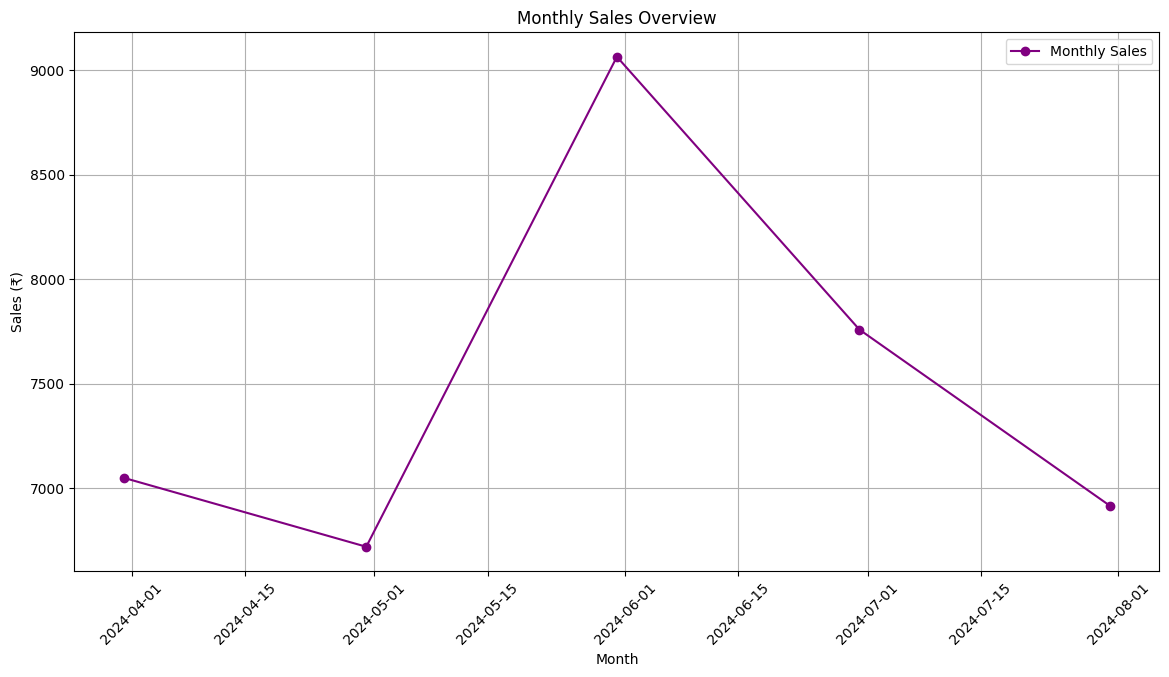

In [125]:

# Monthly Sales Calculation and Visualization
monthly_sales = daily_sales.resample('ME').sum()
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales, marker='o', label='Monthly Sales', color='purple')
plt.title('Monthly Sales Overview')
plt.xlabel('Month')
plt.ylabel('Sales (₹)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

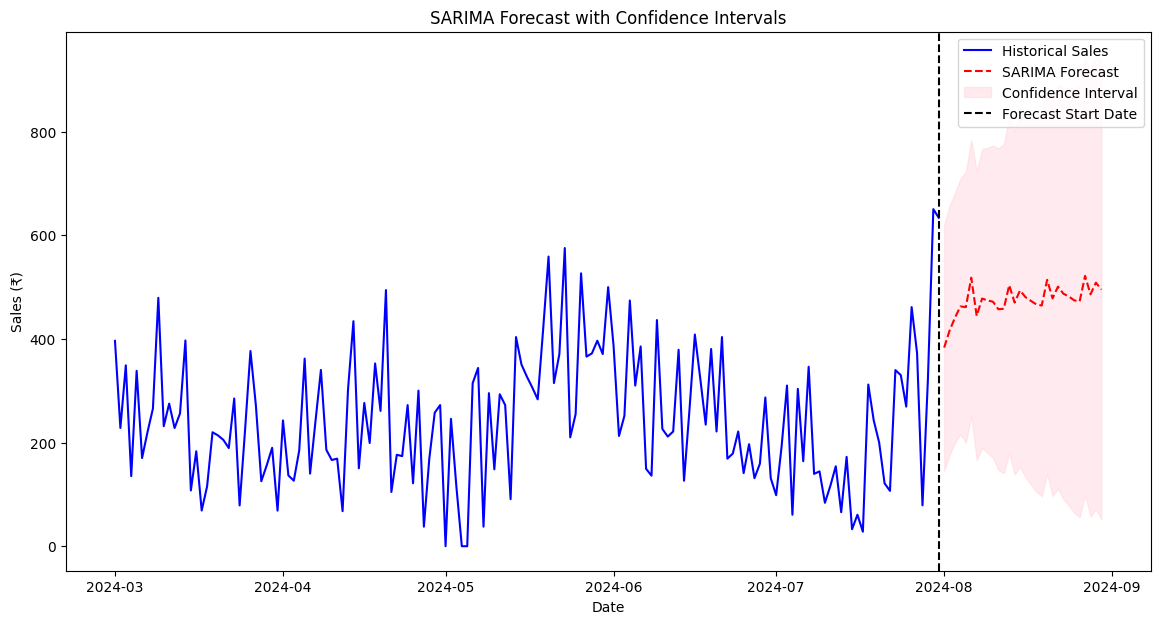

In [126]:
# Plotting the SARIMA forecast with confidence intervals
preds_conf = sarima_model_fit.get_forecast(steps=forecast_days).conf_int()
plt.figure(figsize=(14, 7))
plt.plot(daily_sales, label='Historical Sales', color='blue')
plt.plot(sarima_forecast_series, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(preds_conf.index, preds_conf.iloc[:, 0], preds_conf.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales (₹)')
plt.axvline(x=daily_sales.index[-1], color='black', linestyle='--', label='Forecast Start Date')
plt.legend()
plt.show()

In [127]:
# -----------------------------------------
# Task 3: Forecasting Specific Customer Purchases
# -----------------------------------------

In [128]:
# Group sales data by 'coffee_name' and 'cash_type'
product_sales = data.groupby(['coffee_name', 'cash_type']).resample('D').sum()['money']

In [129]:
# Get all unique coffee_name and cash_type combinations
combinations = product_sales.index.droplevel(2).unique()

In [130]:
# Dictionary to store forecast results for each combination
forecasts = {}

In [131]:
# Loop over each combination of coffee_name and cash_type
for coffee_name, cash_type in combinations:
    print(f"\nProcessing forecast for {coffee_name} ({cash_type})...")


Processing forecast for Americano (card)...

Processing forecast for Americano (cash)...

Processing forecast for Americano with Milk (card)...

Processing forecast for Americano with Milk (cash)...

Processing forecast for Cappuccino (card)...

Processing forecast for Cappuccino (cash)...

Processing forecast for Cocoa (card)...

Processing forecast for Cocoa (cash)...

Processing forecast for Cortado (card)...

Processing forecast for Cortado (cash)...

Processing forecast for Espresso (card)...

Processing forecast for Espresso (cash)...

Processing forecast for Hot Chocolate (card)...

Processing forecast for Hot Chocolate (cash)...

Processing forecast for Latte (card)...

Processing forecast for Latte (cash)...


In [132]:
# Filter data for the current coffee_name and cash_type
selected_sales = product_sales.loc[(coffee_name, cash_type)].dropna()

In [133]:
# Check if there is enough data to forecast
if len(selected_sales) < 30:
    print(f"Insufficient data for {coffee_name} ({cash_type}) - Skipping.")

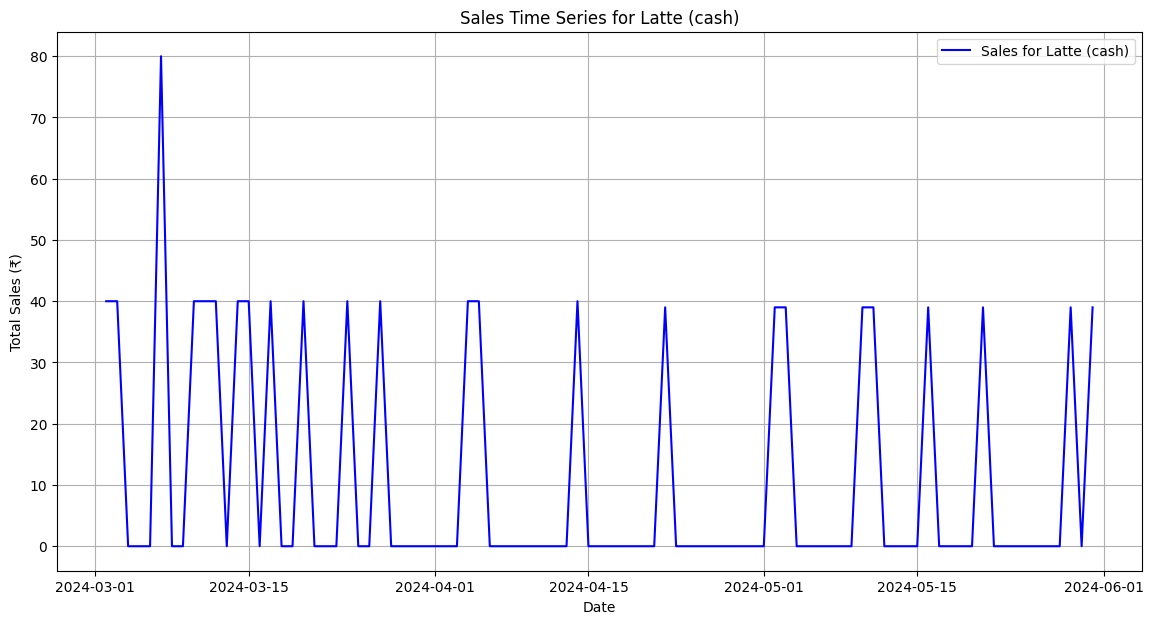

In [134]:
# Plot the selected sales over time
plt.figure(figsize=(14, 7))
plt.plot(selected_sales, label=f'Sales for {coffee_name} ({cash_type})', color='blue')
plt.title(f'Sales Time Series for {coffee_name} ({cash_type})')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
plt.legend()
plt.grid()
plt.show()

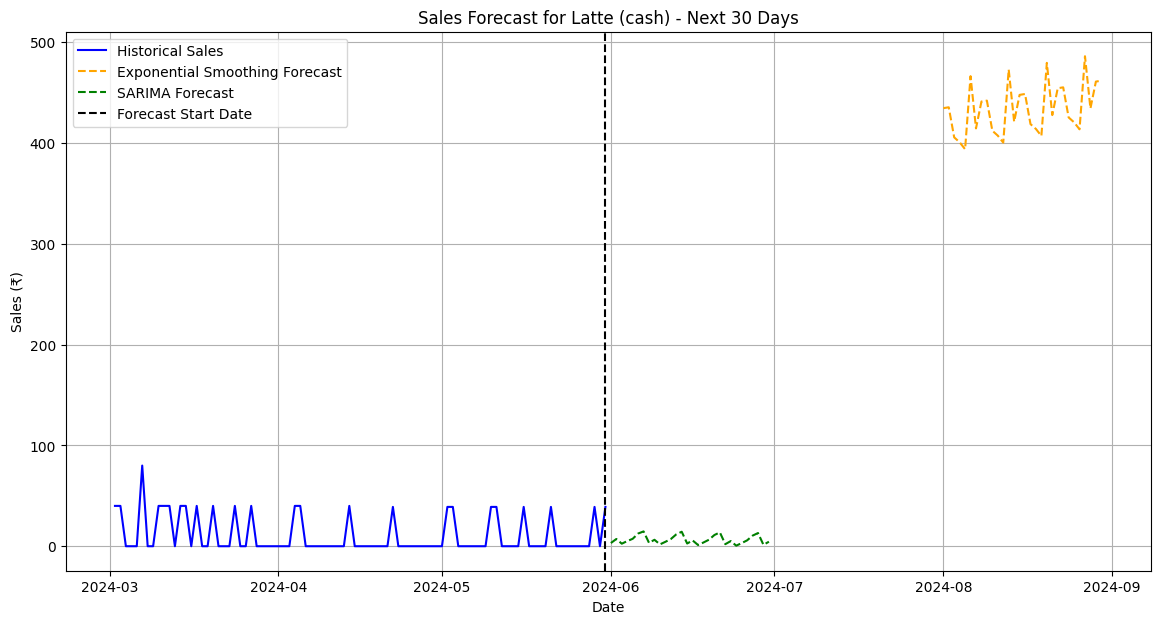

In [135]:
# Plot forecasts
plt.figure(figsize=(14, 7))
plt.plot(selected_sales, label='Historical Sales', color='blue')
if forecast_exp is not None:
    plt.plot(forecast_exp, label='Exponential Smoothing Forecast', color='orange', linestyle='--')
if forecast_sarima is not None:
    plt.plot(forecast_sarima, label='SARIMA Forecast', color='green', linestyle='--')
plt.title(f'Sales Forecast for {coffee_name} ({cash_type}) - Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Sales (₹)')
plt.axvline(x=selected_sales.index[-1], color='black', linestyle='--', label='Forecast Start Date')
plt.legend()
plt.grid()
plt.show()

In [136]:
# Exponential Smoothing Evaluation
if forecast_exp is not None:
    mse_exp = mean_squared_error(recent_actual, forecast_exp[:len(recent_actual)])
    rmse_exp = np.sqrt(mse_exp)
    print(f'Exponential Smoothing - MSE: {mse_exp:.2f}, RMSE: {rmse_exp:.2f}')
else:
    print(f"Exponential Smoothing forecast unavailable for {coffee_name} ({cash_type})")

Exponential Smoothing - MSE: 66916.73, RMSE: 258.68
